In [1]:
# Import required libraries
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import os
import json
from datetime import datetime

# Import our custom modules
from jewelry_improvements import ImprovedJewelryPipeline, JewelryTermEmbeddings, ModernAestheticPrompting
from evaluation_metrics import ComprehensiveEvaluator

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Create directories for outputs
os.makedirs("../before_after", exist_ok=True)
os.makedirs("../results", exist_ok=True)


Using device: cpu


In [2]:
# Define the 8 required test prompts
test_prompts = [
    "channel-set diamond eternity band, 2 mm width, hammered 18k yellow gold, product-only white background",
    "14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light",
    "organic cluster ring with mixed-cut sapphires and diamonds, brushed platinum finish, modern aesthetic",
    "A solid gold cuff bracelet with blue sapphire, with refined simplicity and intentionally crafted for everyday wear",
    "modern signet ring, oval face, engraved gothic initial 'M', high-polish sterling silver, subtle reflection",
    "delicate gold huggie hoops, contemporary styling, isolated on neutral background",
    "stack of three slim rings: twisted gold, plain platinum, black rhodium pavé, editorial lighting",
    "bypass ring with stones on it, with refined simplicity and intentionally crafted for everyday wear"
]

print(f"Loaded {len(test_prompts)} test prompts")
for i, prompt in enumerate(test_prompts, 1):
    print(f"{i:2d}. {prompt}")


Loaded 8 test prompts
 1. channel-set diamond eternity band, 2 mm width, hammered 18k yellow gold, product-only white background
 2. 14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light
 3. organic cluster ring with mixed-cut sapphires and diamonds, brushed platinum finish, modern aesthetic
 4. A solid gold cuff bracelet with blue sapphire, with refined simplicity and intentionally crafted for everyday wear
 5. modern signet ring, oval face, engraved gothic initial 'M', high-polish sterling silver, subtle reflection
 6. delicate gold huggie hoops, contemporary styling, isolated on neutral background
 7. stack of three slim rings: twisted gold, plain platinum, black rhodium pavé, editorial lighting
 8. bypass ring with stones on it, with refined simplicity and intentionally crafted for everyday wear


In [3]:
# Initialize the improved jewelry pipeline
print("Initializing improved jewelry pipeline...")
pipeline = ImprovedJewelryPipeline(device=device)
print("Pipeline loaded successfully!")

# Initialize evaluator
print("Initializing comprehensive evaluator...")
evaluator = ComprehensiveEvaluator(device=device)
print("Evaluator loaded successfully!")


Initializing improved jewelry pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Pipeline loaded successfully!
Initializing comprehensive evaluator...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Evaluator loaded successfully!


In [4]:
# Generate baseline images for all prompts
print("Generating baseline images...")
baseline_images = []
baseline_results = []

for i, prompt in enumerate(test_prompts, 1):
    print(f"\nGenerating baseline for prompt {i}/8...")
    print(f"Prompt: {prompt}")
    
    # Use fixed seed for reproducibility
    seed = 42 + i
    baseline_img = pipeline.generate_baseline(
        prompt=prompt,
        num_images=1,
        seed=seed,
        num_inference_steps=30  # Faster for demo
    )[0]
    
    baseline_images.append(baseline_img)
    
    # Save baseline image
    baseline_path = f"../before_after/prompt{i:02d}_baseline.png"
    baseline_img.save(baseline_path)
    print(f"Saved baseline to: {baseline_path}")

print(f"\n✅ Generated {len(baseline_images)} baseline images")


Generating baseline images...

Generating baseline for prompt 1/8...
Prompt: channel-set diamond eternity band, 2 mm width, hammered 18k yellow gold, product-only white background


  0%|          | 0/30 [00:00<?, ?it/s]

Saved baseline to: ../before_after/prompt01_baseline.png

Generating baseline for prompt 2/8...
Prompt: 14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light


  0%|          | 0/30 [00:00<?, ?it/s]

Saved baseline to: ../before_after/prompt02_baseline.png

Generating baseline for prompt 3/8...
Prompt: organic cluster ring with mixed-cut sapphires and diamonds, brushed platinum finish, modern aesthetic


  0%|          | 0/30 [00:00<?, ?it/s]

Saved baseline to: ../before_after/prompt03_baseline.png

Generating baseline for prompt 4/8...
Prompt: A solid gold cuff bracelet with blue sapphire, with refined simplicity and intentionally crafted for everyday wear


  0%|          | 0/30 [00:00<?, ?it/s]

Saved baseline to: ../before_after/prompt04_baseline.png

Generating baseline for prompt 5/8...
Prompt: modern signet ring, oval face, engraved gothic initial 'M', high-polish sterling silver, subtle reflection


  0%|          | 0/30 [00:00<?, ?it/s]

Saved baseline to: ../before_after/prompt05_baseline.png

Generating baseline for prompt 6/8...
Prompt: delicate gold huggie hoops, contemporary styling, isolated on neutral background


  0%|          | 0/30 [00:00<?, ?it/s]

Saved baseline to: ../before_after/prompt06_baseline.png

Generating baseline for prompt 7/8...
Prompt: stack of three slim rings: twisted gold, plain platinum, black rhodium pavé, editorial lighting


  0%|          | 0/30 [00:00<?, ?it/s]

Saved baseline to: ../before_after/prompt07_baseline.png

Generating baseline for prompt 8/8...
Prompt: bypass ring with stones on it, with refined simplicity and intentionally crafted for everyday wear


  0%|          | 0/30 [00:00<?, ?it/s]

Saved baseline to: ../before_after/prompt08_baseline.png

✅ Generated 8 baseline images


In [5]:
# Generate improved images for all prompts
print("Generating improved images...")
improved_images = []
improved_results = []

for i, prompt in enumerate(test_prompts, 1):
    print(f"\nGenerating improved for prompt {i}/8...")
    print(f"Prompt: {prompt}")
    
    # Use same seed for fair comparison
    seed = 42 + i
    
    # Generate multiple candidates and select best
    candidate_images = pipeline.generate_improved(
        prompt=prompt,
        num_images=3,  # Generate 3 candidates
        seed=seed,
        num_inference_steps=30  # Faster for demo
    )
    
    # Evaluate candidates and select best
    best_score = -1
    best_image = candidate_images[0]
    
    print(f"Evaluating {len(candidate_images)} candidates...")
    for j, candidate in enumerate(candidate_images):
        eval_result = evaluator.evaluate_image(candidate, prompt)
        score = eval_result['overall_quality_score']
        print(f"  Candidate {j+1}: {score:.3f}")
        
        if score > best_score:
            best_score = score
            best_image = candidate
    
    improved_images.append(best_image)
    
    # Save improved image
    improved_path = f"../before_after/prompt{i:02d}_yours.png"
    best_image.save(improved_path)
    print(f"Saved improved to: {improved_path}")
    print(f"Best score: {best_score:.3f}")

print(f"\n✅ Generated {len(improved_images)} improved images")


Token indices sequence length is longer than the specified maximum sequence length for this model (89 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['background , high - end jewelry , luxury craftsmanship , premium materials']


Generating improved images...

Generating improved for prompt 1/8...
Prompt: channel-set diamond eternity band, 2 mm width, hammered 18k yellow gold, product-only white background
Enhanced prompt: (channel-set:1.3) (gemstones precisely set in parallel grooves, flush with the band for a sleek look) (diamond:1.3) (eternity:1.3) band (ring with a continuous circle of identical gemstones all around the band), 2 mm width, hammered 18k yellow (gold:1.3), product-only white background, high-end jewelry, luxury craftsmanship, premium materials
Negative prompt: vintage, antique, ornate, fussy, busy, cluttered, cheap, plastic, fake, costume jewelry, tacky, overly decorative, baroque, rococo, gaudy, flashy, low quality, mass produced, generic, outdated style


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating 3 candidates...
  Candidate 1: 0.304
  Candidate 2: 0.338


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['lifestyle macro shot , soft natural light , high - end jewelry , luxury craftsmanship , premium materials']


  Candidate 3: 0.351
Saved improved to: ../before_after/prompt01_yours.png
Best score: 0.351

Generating improved for prompt 2/8...
Prompt: 14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light
Enhanced prompt: 14k rose-(gold:1.3) (threader:1.3) (long, delicate earring that threads through the ear with a thin chain or bar) earrings, (bezel-set:1.3) (gemstone fully enclosed by a thin metal rim for a modern, secure setting) round lab (diamond:1.3) ends, lifestyle macro shot, soft natural light, high-end jewelry, luxury craftsmanship, premium materials
Negative prompt: vintage, antique, ornate, fussy, busy, cluttered, cheap, plastic, fake, costume jewelry, tacky, overly decorative, baroque, rococo, gaudy, flashy, low quality, mass produced, generic, outdated style


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating 3 candidates...
  Candidate 1: 0.330
  Candidate 2: 0.360
  Candidate 3: 0.331
Saved improved to: ../before_after/prompt02_yours.png
Best score: 0.360

Generating improved for prompt 3/8...
Prompt: organic cluster ring with mixed-cut sapphires and diamonds, brushed platinum finish, modern aesthetic
Enhanced prompt: organic (cluster:1.3) (group of multiple gemstones arranged together in one setting) ring with mixed-cut sapphires and diamonds, brushed (platinum:1.3) finish, modern aesthetic, current aesthetic with clean lines, quality materials, and thoughtful design, high-end jewelry, luxury craftsmanship, premium materials
Negative prompt: vintage, antique, ornate, fussy, busy, cluttered, cheap, plastic, fake, costume jewelry, tacky, overly decorative, baroque, rococo, gaudy, flashy, low quality, mass produced, generic, outdated style


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating 3 candidates...
  Candidate 1: 0.361
  Candidate 2: 0.374
  Candidate 3: 0.364
Saved improved to: ../before_after/prompt03_yours.png
Best score: 0.374

Generating improved for prompt 4/8...
Prompt: A solid gold cuff bracelet with blue sapphire, with refined simplicity and intentionally crafted for everyday wear
Enhanced prompt: A solid (gold:1.3) (cuff:1.3) (rigid, open-ended bracelet worn on the wrist) bracelet with blue (sapphire:1.3), with refined simplicity and intentionally crafted for everyday wear, sophisticated elegance with attention to subtle details and proportions, high-end jewelry, luxury craftsmanship, premium materials
Negative prompt: vintage, antique, ornate, fussy, busy, cluttered, cheap, plastic, fake, costume jewelry, tacky, overly decorative, baroque, rococo, gaudy, flashy, low quality, mass produced, generic, outdated style


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating 3 candidates...
  Candidate 1: 0.365
  Candidate 2: 0.354
  Candidate 3: 0.359
Saved improved to: ../before_after/prompt04_yours.png
Best score: 0.365

Generating improved for prompt 5/8...
Prompt: modern signet ring, oval face, engraved gothic initial 'M', high-polish sterling silver, subtle reflection
Enhanced prompt: modern (signet:1.3) (flat-topped ring, often engraved with a design or initials) ring, oval face, engraved gothic initial 'M', high-polish sterling (silver:1.3), subtle reflection, current aesthetic with clean lines, quality materials, and thoughtful design, high-end jewelry, luxury craftsmanship, premium materials
Negative prompt: vintage, antique, ornate, fussy, busy, cluttered, cheap, plastic, fake, costume jewelry, tacky, overly decorative, baroque, rococo, gaudy, flashy, low quality, mass produced, generic, outdated style


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating 3 candidates...
  Candidate 1: 0.357
  Candidate 2: 0.360
  Candidate 3: 0.365
Saved improved to: ../before_after/prompt05_yours.png
Best score: 0.365

Generating improved for prompt 6/8...
Prompt: delicate gold huggie hoops, contemporary styling, isolated on neutral background
Enhanced prompt: delicate (gold:1.3) (huggie:1.3) (small hoop earring that fits closely around the earlobe) hoops, contemporary styling, isolated on neutral background, current design trends with refined simplicity and intentional craftsmanship, high-end jewelry, luxury craftsmanship, premium materials
Negative prompt: vintage, antique, ornate, fussy, busy, cluttered, cheap, plastic, fake, costume jewelry, tacky, overly decorative, baroque, rococo, gaudy, flashy, low quality, mass produced, generic, outdated style


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating 3 candidates...
  Candidate 1: 0.350
  Candidate 2: 0.365
  Candidate 3: 0.346
Saved improved to: ../before_after/prompt06_yours.png
Best score: 0.365

Generating improved for prompt 7/8...
Prompt: stack of three slim rings: twisted gold, plain platinum, black rhodium pavé, editorial lighting
Enhanced prompt: stack of three slim rings: twisted (gold:1.3), plain (platinum:1.3), black rhodium (pavé:1.3) (surface covered with small, closely set stones creating a sparkling texture), editorial lighting, high-end jewelry, luxury craftsmanship, premium materials
Negative prompt: vintage, antique, ornate, fussy, busy, cluttered, cheap, plastic, fake, costume jewelry, tacky, overly decorative, baroque, rococo, gaudy, flashy, low quality, mass produced, generic, outdated style


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating 3 candidates...
  Candidate 1: 0.344
  Candidate 2: 0.348
  Candidate 3: 0.373
Saved improved to: ../before_after/prompt07_yours.png
Best score: 0.373

Generating improved for prompt 8/8...
Prompt: bypass ring with stones on it, with refined simplicity and intentionally crafted for everyday wear
Enhanced prompt: (bypass:1.3) (ring where the band ends curve past each other without joining) ring with stones on it, with refined simplicity and intentionally crafted for everyday wear, sophisticated elegance with attention to subtle details and proportions, high-end jewelry, luxury craftsmanship, premium materials
Negative prompt: vintage, antique, ornate, fussy, busy, cluttered, cheap, plastic, fake, costume jewelry, tacky, overly decorative, baroque, rococo, gaudy, flashy, low quality, mass produced, generic, outdated style


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating 3 candidates...
  Candidate 1: 0.352
  Candidate 2: 0.370
  Candidate 3: 0.356
Saved improved to: ../before_after/prompt08_yours.png
Best score: 0.370

✅ Generated 8 improved images


In [6]:
# Comprehensive evaluation and comparison
print("Performing comprehensive evaluation...")

# Create image pairs for batch evaluation
image_pairs = list(zip(baseline_images, improved_images))

# Batch evaluate all pairs
batch_results = evaluator.batch_evaluate(image_pairs, test_prompts)

# Display results
print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)

stats = batch_results['aggregate_stats']
print(f"\nAggregate Statistics:")
print(f"  Total images evaluated: {stats['total_images']}")
print(f"  Successful improvements: {stats['improvements_count']}/{stats['total_images']} ({stats['improvements_count']/stats['total_images']*100:.1f}%)")
print(f"  Mean CLIP similarity gain: {stats['mean_clip_gain']:.4f}")
print(f"  Mean aesthetic score gain: {stats['mean_aesthetic_gain']:.4f}")
print(f"  Mean overall quality gain: {stats['mean_quality_gain']:.4f}")

# Individual results
print(f"\nIndividual Results:")
for i, comparison in enumerate(batch_results['individual_comparisons'], 1):
    improvements = comparison['improvements']
    print(f"\nPrompt {i:2d}: {test_prompts[i-1][:50]}...")
    print(f"  CLIP gain:      {improvements['clip_similarity_gain']:+.4f}")
    print(f"  Aesthetic gain: {improvements['aesthetic_score_gain']:+.4f}")
    print(f"  Quality gain:   {improvements['overall_quality_gain']:+.4f}")

# Save results
results_file = f"../results/evaluation_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(results_file, 'w') as f:
    # Convert numpy types to regular python types for JSON serialization
    json_results = json.loads(json.dumps(batch_results, default=lambda x: float(x) if isinstance(x, np.floating) else str(x)))
    json.dump(json_results, f, indent=2)
print(f"\n💾 Results saved to: {results_file}")


Performing comprehensive evaluation...

EVALUATION RESULTS

Aggregate Statistics:
  Total images evaluated: 8
  Successful improvements: 3/8 (37.5%)
  Mean CLIP similarity gain: -0.0094
  Mean aesthetic score gain: 0.0022
  Mean overall quality gain: -0.0046

Individual Results:

Prompt  1: channel-set diamond eternity band, 2 mm width, ham...
  CLIP gain:      -0.0195
  Aesthetic gain: -0.0038
  Quality gain:   -0.0117

Prompt  2: 14k rose-gold threader earrings, bezel-set round l...
  CLIP gain:      -0.0271
  Aesthetic gain: +0.0004
  Quality gain:   -0.0163

Prompt  3: organic cluster ring with mixed-cut sapphires and ...
  CLIP gain:      +0.0156
  Aesthetic gain: +0.0031
  Quality gain:   +0.0089

Prompt  4: A solid gold cuff bracelet with blue sapphire, wit...
  CLIP gain:      -0.0273
  Aesthetic gain: -0.0018
  Quality gain:   -0.0136

Prompt  5: modern signet ring, oval face, engraved gothic ini...
  CLIP gain:      -0.0133
  Aesthetic gain: +0.0002
  Quality gain:   -0.0062


Creating visual comparison...
💾 Visual comparison saved to: ../results/visual_comparison.png


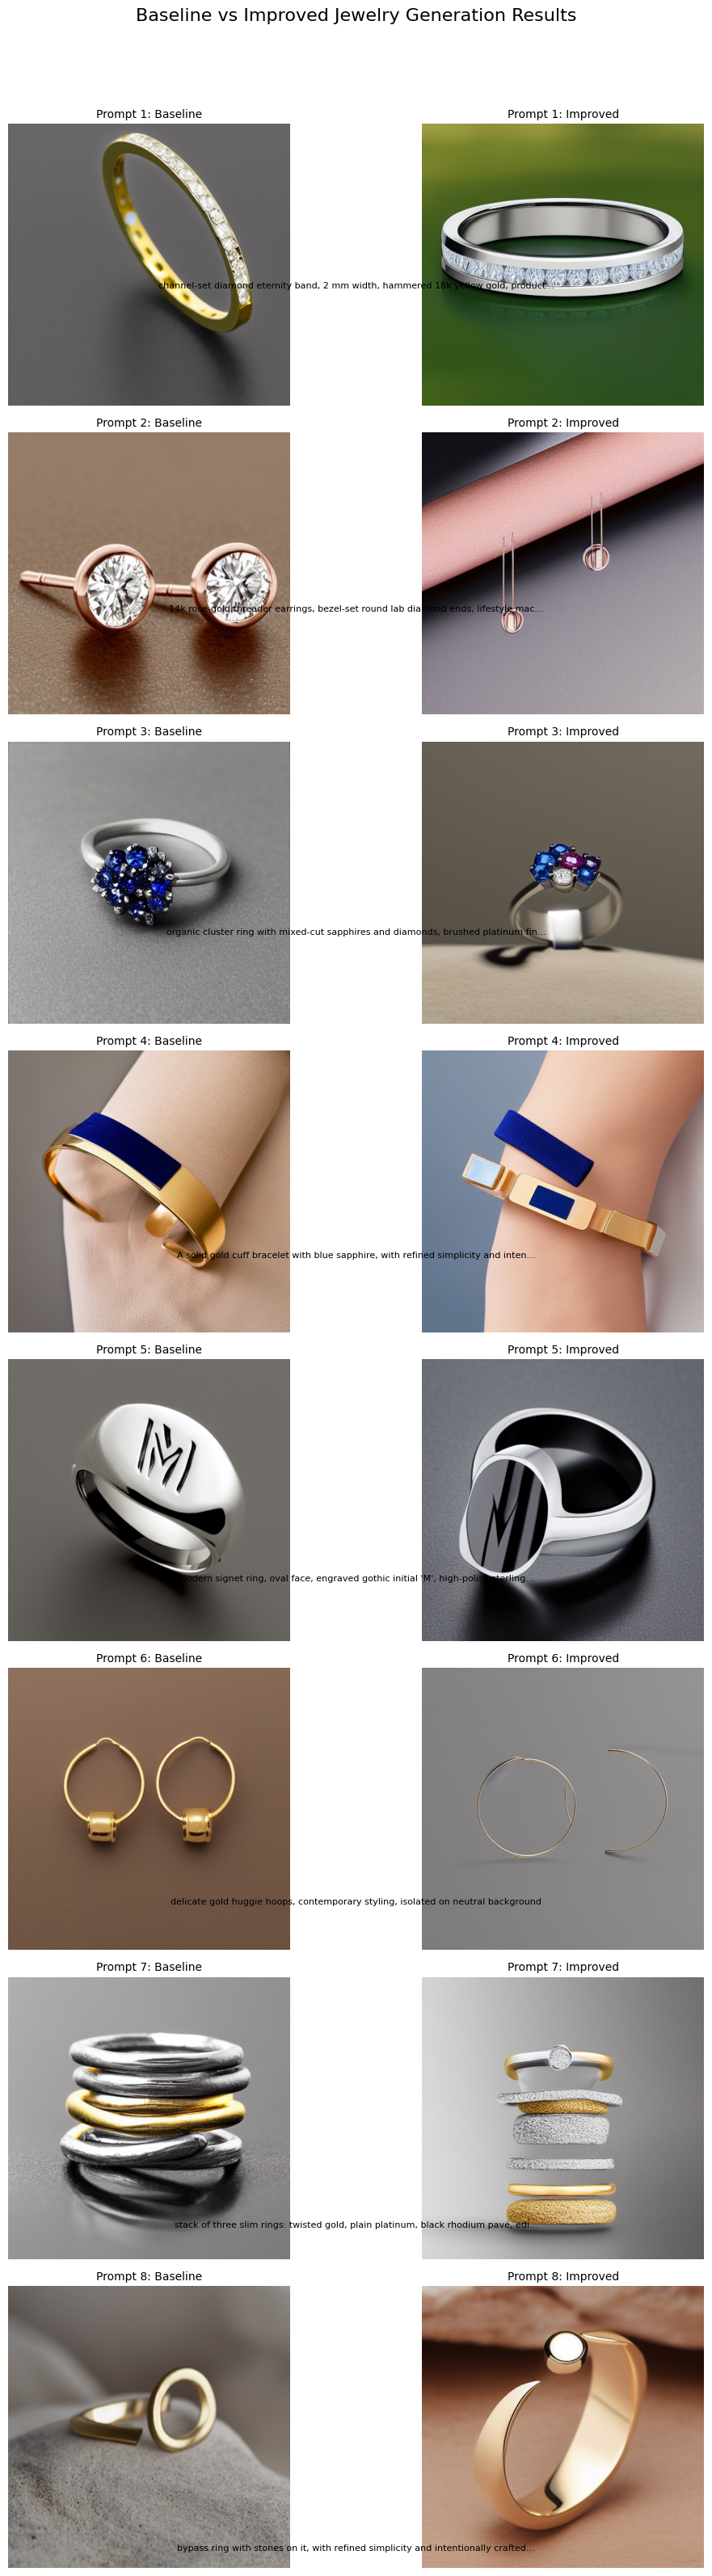

In [7]:
# Visual comparison of results
print("Creating visual comparison...")

# Create a large comparison grid
fig, axes = plt.subplots(len(test_prompts), 2, figsize=(12, 4*len(test_prompts)))
fig.suptitle('Baseline vs Improved Jewelry Generation Results', fontsize=16, y=0.995)

for i, (baseline_img, improved_img) in enumerate(zip(baseline_images, improved_images)):
    # Baseline image
    axes[i, 0].imshow(baseline_img)
    axes[i, 0].set_title(f'Prompt {i+1}: Baseline', fontsize=10)
    axes[i, 0].axis('off')
    
    # Improved image
    axes[i, 1].imshow(improved_img)
    axes[i, 1].set_title(f'Prompt {i+1}: Improved', fontsize=10)
    axes[i, 1].axis('off')
    
    # Add prompt text below
    prompt_text = test_prompts[i]
    if len(prompt_text) > 80:
        prompt_text = prompt_text[:80] + "..."
    
    fig.text(0.5, 0.95 - (i+0.5)/len(test_prompts), prompt_text, 
             ha='center', va='center', fontsize=8, wrap=True)

plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Save comparison
comparison_path = "../results/visual_comparison.png"
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
print(f"💾 Visual comparison saved to: {comparison_path}")

plt.show()
